# Lesson 2

**Goal.** We will build and train a (very primitive) **character-level language model** on the dataset `names.txt`. The objective is to create a model that generates sequences of letters corresponding to new names. We will first construct a simple **count-based model** and evaluate it in terms of **MLE** (Maximum Likelihood Estimation). We will then train a **one-layer neural network** to become familiar with gradient descent.

This lesson is based on **Andrej Karpathy’s “Neural Networks: Zero to Hero”** video series  
(https://karpathy.ai/).


## Notation

- Dataset: list of names $w\in\mathcal{D}$, each a string over an alphabet $\mathcal{A}$ including a special boundary token `"."`. This special characters stand for the beginng and the end of a name.
- Vocabulary size: $V = |\mathcal{A}| = 26+1 $.
- Encode characters with a bijection:
$$
\mathrm{stoi}:\mathcal{A}\to\{0,\dots,V-1\},\qquad \mathrm{stoi}('.')=0,
$$
The name $\mathrm{stoi}$ stands for string to interger, and we denote $\mathrm{itos}=\mathrm{stoi}^{-1}$. 

A **bigram model** assumes:
$$
P(c_t \mid c_{t-1}, c_{t-2},\dots) \approx P(c_t \mid c_{t-1}),
$$
i.e. a first-order Markov chain over characters.

---

## We will construct:

1. The Bigram count matrix $N\in\mathbb{N}^{V\times V}$
2. The Bigram probability matrix $P\in[0,1]^{V\times V}$.
3. Sampling procedure to generate new names
4. Negative log-likelihood (NLL) evaluation of the model
5. Neural formulation: one-hot input $\to$ linear logits $\to$ softmax $\to$ NLL, trained by gradient descent


In [4]:
# if running on google colab, run this cell
%cd /content
!rm -rf mini-course-DL
!git clone https://github.com/AdamArras/mini-course-DL.git
%cd mini-course-DL

[Errno 2] No such file or directory: '/content'
/home/adam/Desktop/Learning/nn-zero_to_hero/my course/mini-course-DL
Cloning into 'mini-course-DL'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 27 (delta 3), reused 27 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 136.37 KiB | 924.00 KiB/s, done.
Resolving deltas: 100% (3/3), done.
/home/adam/Desktop/Learning/nn-zero_to_hero/my course/mini-course-DL/mini-course-DL


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## 1) Setup and load dataset

**Exercise.**
1. Load `names.txt` into a list `words`.
2. Display: 
   - the 10 first names of the dataset.
   - the total number of neames.
   - the size of the shorted and the longuest name.

remark : if you have problem with finding the path for the files, do the comand `%ls` 


In [6]:
# TODO: imports + load words + sanity checks

In [7]:
file = open('data/names.txt', 'r') 
words = file.read().splitlines() 
file.close() 

print(type(words))
print(words[:10])
print(len(words))
print('min lenght = '+str(min([len(w) for w in words]))+ ' and max lenght = ' +str(max([len(w) for w in words])))


<class 'list'>
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033
min lenght = 2 and max lenght = 15


## 2) Build vocabulary and integer encoding

**Exercise.**
1. Collect characters:
$$
\mathcal{A} = \text{sorted unique characters in the dataset}.
$$
2. Build dictionaries `stoi`, `itos` with `"."` mapped to 0.
3. Define `vocab_size = V`.

**Check.** Print `itos` and `vocab_size`.



In [8]:
# TODO: build chars, stoi, itos, vocab_size


In [9]:
alphabet = str('.abcdefghijklmnopqrstuvwxyz')
vocab_size = len(alphabet)
itos = {i:alphabet[i] for i in range(vocab_size)}
stoi = {alphabet[i]:i for i in range(vocab_size)}

## 3) Bigram counts $N$

For each word $w = w_1\cdots w_L$, form the augmented sequence:
$$
(. , w_1, w_2, \dots, w_L, .)
$$
where $.$ is our special characters, and count transitions $(c_{\text{prev}}\to c_{\text{next}})$.

Define:
$$
N_{i,j} = \#\{ \text{times character } i \text{ is followed by character } j\}.
$$

**Exercise.**
1. Initialize $N\in\mathbb{N}^{V\times V}$ with zeros (integer dtype).
2. Loop over all words and all adjacent pairs (including boundary `"."`).
3. Increment the appropriate cell in $N$.



In [10]:
# TODO: build N (VxV) bigram count matrix

In [11]:
N = torch.zeros((vocab_size,vocab_size),dtype =torch.int32)
for names in words:
    augmented_name = '.'+str(names)+'.'
    for ch1,ch2 in zip(augmented_name,augmented_name[1:]):
        i1,i2 = stoi[ch1],stoi[ch2]
        N[i1,i2] += 1

## 4) Visualize $N$

**Exercise.**
- Plot $N$ as an image (e.g. `imshow`).
- Overlay:
  - the bigram label `itos[i] + itos[j]`
  - the count $N_{i,j}$

This lets you visually inspect which transitions are frequent.



In [12]:
# TODO: visualize N with matplotlib


([<matplotlib.axis.YTick at 0x7997e3442960>,
 [Text(0, 0, '.'),
  Text(0, 1, 'a'),
  Text(0, 2, 'b'),
  Text(0, 3, 'c'),
  Text(0, 4, 'd'),
  Text(0, 5, 'e'),
  Text(0, 6, 'f'),
  Text(0, 7, 'g'),
  Text(0, 8, 'h'),
  Text(0, 9, 'i'),
  Text(0, 10, 'j'),
  Text(0, 11, 'k'),
  Text(0, 12, 'l'),
  Text(0, 13, 'm'),
  Text(0, 14, 'n'),
  Text(0, 15, 'o'),
  Text(0, 16, 'p'),
  Text(0, 17, 'q'),
  Text(0, 18, 'r'),
  Text(0, 19, 's'),
  Text(0, 20, 't'),
  Text(0, 21, 'u'),
  Text(0, 22, 'v'),
  Text(0, 23, 'w'),
  Text(0, 24, 'x'),
  Text(0, 25, 'y'),
  Text(0, 26, 'z')])

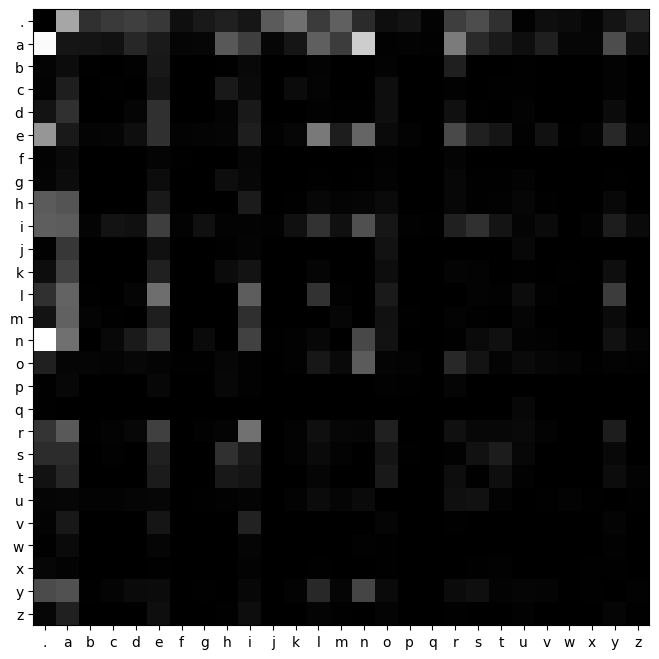

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(N, cmap = 'grey')
plt.xticks(range(27), [itos[i] for i in range(27)])
plt.yticks(range(27), [itos[i] for i in range(27)])

## 5) Convert counts to probabilities $P$ 

Raw MLE would be:
$$
P_{i,j} = \frac{N_{i,j}}{\sum_{k} N_{i,k}}.
$$

We use **Laplace smoothing** to avoid zeros:
$$
P_{i,j} = \frac{N_{i,j} + 1}{\sum_k (N_{i,k}+1)}.
$$

**Exercise.**
1. Construct $P$ as float.
2. Normalize each row so it sums to 1:
$$
\sum_j P_{i,j} = 1\ \text{for all } i.
$$
3. Verify row sums are ~1.



In [14]:
# TODO: compute P from N using Laplace smoothingP = torch.zeros_like(N, dtype = float)


In [15]:
P = torch.zeros_like(N,dtype = float)
P += N + 1.0
P = P / P.sum(1, keepdim=True)
sum(P[0,:])

tensor(1.0000, dtype=torch.float64)

## 6) Sampling from the bigram model

We generate names by sampling a Markov chain:

Initialize $c_0 = '.'$ (index 0). Then iterate:
$$
c_{t} \sim \mathrm{Categorical}(P_{c_{t-1}, :})
$$
until $c_t='.'$ again, then stop.

**Exercise.**
- Write a loop that generates, say, 5–20 names.
- Use a fixed `torch.Generator().manual_seed(...)` for reproducibility.



In [19]:
# TODO: sample names from P (bigram Markov chain)

In [20]:
g = torch.Generator().manual_seed(42)

nb_names = 10
for nb in range(nb_names):
    name = []
    it = 0
    while True:
        p = P[it,:]
        it = torch.multinomial(p,num_samples=1,generator = g).item()
        ch = itos[it]
        if it == 0:
            break
        name.append(ch)
    print("".join(name))

anugeenvi
s
mabidushan
stan
silaylelaremah
li
le
epiachalen
diza
k


## 7) Evaluate model: log-likelihood.

For each observed bigram $(i\to j)$, the model assigns probability $P_{i,j}$.

Total log-likelihood over the dataset:
$$
\log \mathcal{L} = \sum_{(i\to j)\ \text{in data}} \log P_{i,j}.
$$

Negative log-likelihood (NLL) per bigram:
$$
\mathrm{NLL} = -\frac{1}{N_{\text{bigrams}}}\sum \log P_{i,j}.
$$

**Exercise.**
- Compute total log-likelihood and average NLL.
- (Optional) Print a few bigrams and their probabilities.



In [21]:
# TODO: compute log-likelihood and NLL for the dataset under P


In [22]:
log_likelihood = 0.0
count = 0

for word in words:
    augmented = "." + word + "."
    for ch1, ch2 in zip(augmented, augmented[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        log_likelihood += torch.log(P[i, j])
        count += 1

nll = -log_likelihood / count
print(nll.item())

2.454576820116076


## 8) Neural formulation of the bigram model (conceptual step)

In this part, we reformulate the bigram model as a **neural network**.
Nothing fundamentally new is learned yet, the goal is to understand how
**counting → probabilities** can be replaced by **parameters → optimization**.

### Mathematical model

Let:
- Vocabulary size: $V$
- Training bigrams: $(x_t, y_t)$, where  
  $x_t \in {0,\ldots,V−1}$ is the previous character index,  
  $y_t \in \{0,\ldots,V−1\}$ is the next character index.

We introduce a parameter matrix:
$W \in \mathbb{R}^{V×V}$.

Interpretation:
- Row $i$ of $W$ contains the logits for predicting the next character,
  given that the previous character index is $i$.

### One-hot encoding

For each input index $x_t \in \{0,\ldots,V−1\}$, define its one-hot vector: $onehot(x_t) \in \mathbb{R}^V$ to be the associated vector basis in $\mathbb{R}^{\{0,\ldots,V−1\}} \simeq \mathbb{R}^V$.

Stacking all examples gives:
$X ∈ \mathbb{R}^{N×V}.$

### Forward pass

For each example:
$l_t = onehot(x_t) · W \in \mathbb{R}^V.$ (Here $l$ stands for logits).

Convert logits to probabilities using softmax:
$$p_{t,j} = \frac{ \exp(l_{t,j}) }{ \sum_k exp(l_{t,k})}$$

This models:
$p_{t,j} ≈ P(y_t = j | x_t).$

### Loss (Negative Log-Likelihood)

We train by minimizing the negative log-likelihood (NLL):
$$L_{NLL} = \frac{-1}{N}  \sum_t \log p_{t, y_t}.$$

This is exactly maximum likelihood estimation for the bigram model,
written in differentiable, parametric form.

At this stage, **do not add regularization yet**.
The focus is understanding logits, softmax, and NLL.

In [23]:
# TODO: build xs, ys over the full dataset of bigrams

In [24]:
xs,ys = [],[]
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        it1,it2 = stoi[ch1],stoi[ch2]
        xs.append(it1)
        ys.append(it2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

import torch.nn.functional as F

X = F.one_hot(xs, num_classes = vocab_size).float()

## 9) Gradient descent training loop (optimization mechanics)

We now explain how PyTorch optimizes the parameter matrix
$$
W \in \mathbb{R}^{V \times V}.
$$

### Optimization objective

We minimize the **negative log-likelihood (NLL)**, with
quadratic ($L^2$ / Frobenius) regularization:
$$
\mathcal{L}
=
\mathcal{L}_{\text{NLL}}
+
\lambda \|W\|_F^2,
\qquad
\|W\|_F^2 = \sum_{i,j} W_{i,j}^2.
$$

- Setting $\lambda = 0$ corresponds to **pure maximum likelihood estimation (MLE)**.
- Introduce $\lambda > 0$ only after the basic training loop works.

### How gradients work in PyTorch

- Tensors created with `requires_grad=True` record their computation graph.
- Calling `loss.backward()` applies **reverse-mode automatic differentiation**.
- After the backward pass, `W.grad` stores the gradient:
$$
W.\text{grad} = \nabla_W \mathcal{L}.
$$
- Gradients **accumulate across iterations**, so they must be reset manually
  at each training step.

### Gradient descent update

With learning rate $\eta > 0$, parameters are updated according to:
$$
W \leftarrow W - \eta \nabla_W \mathcal{L}.
$$

In PyTorch, this update must be performed **without tracking gradients**
(e.g. inside a `torch.no_grad()` block).

### Training loop structure

Each training iteration must contain the following four steps:

1. **Forward pass**
   - Compute logits: $\text{logits} = XW$
   - Compute the loss (NLL, optionally plus regularization)

2. **Backward pass**
   - Reset stored gradients
   - Call `loss.backward()` to compute gradients

3. **Parameter update**
   - Update $W$ using gradient descent
   - Do not track gradients during the update

4. **Monitoring**
   - Record the loss value to verify that it decreases over iterations

### Goal of this section

Understand explicitly:
- how probabilistic models become **trainable neural models**,
- where gradients are stored,
- and how parameters are updated by gradient descent.

In [ ]:
# TODO: built the Gradient descent training loop

In [25]:
K = 1000
eta = 10.0 # this is a big value in practice we will see eta of oder 10^{-1}
lam = 0.02

loss_hist = []

g = torch.Generator().manual_seed(42)
W = torch.randn((vocab_size, vocab_size), generator=g, requires_grad=True)

for k in range(K):
    # 1) forward: logits + loss
    logits = X @ W
    nll = F.cross_entropy(logits, ys)          
    reg = lam * (W**2).mean()                
    loss = nll + reg

    # 2) backward: zero grads + backprop
    W.grad = None
    loss.backward()

    # 3) update: gradient descent step (no grad tracking)
    with torch.no_grad():
        W -= eta * W.grad

    # 4) monitor
    loss_hist.append(loss.item())
    if k % 100 == 0:
        print(f"{k:4d}/{K}  loss={loss.item():.4f}  nll={nll.item():.4f}  reg={reg.item():.4f}")

   0/1000  loss=3.7163  nll=3.6966  reg=0.0197
 100/1000  loss=2.5870  nll=2.5673  reg=0.0197
 200/1000  loss=2.5331  nll=2.5101  reg=0.0230
 300/1000  loss=2.5165  nll=2.4913  reg=0.0252
 400/1000  loss=2.5092  nll=2.4825  reg=0.0268
 500/1000  loss=2.5054  nll=2.4775  reg=0.0279
 600/1000  loss=2.5032  nll=2.4745  reg=0.0288
 700/1000  loss=2.5018  nll=2.4724  reg=0.0294
 800/1000  loss=2.5009  nll=2.4709  reg=0.0299
 900/1000  loss=2.5002  nll=2.4699  reg=0.0303


In [26]:
P_learned = torch.softmax(W, dim=1)

P_learned.sum(1)[:5]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SliceBackward0>)

In [27]:
print(P[4,:])
print(P_learned[4,:])


tensor([9.3609e-02, 2.3610e-01, 3.6212e-04, 7.2424e-04, 2.7159e-02, 2.3248e-01,
        1.0864e-03, 4.7076e-03, 2.1546e-02, 1.2222e-01, 1.8106e-03, 7.2424e-04,
        1.1045e-02, 5.6129e-03, 5.7940e-03, 6.8622e-02, 1.8106e-04, 3.6212e-04,
        7.6951e-02, 5.4318e-03, 9.0531e-04, 1.6839e-02, 3.2591e-03, 4.3455e-03,
        1.8106e-04, 5.7577e-02, 3.6212e-04], dtype=torch.float64)
tensor([0.0890, 0.2301, 0.0037, 0.0037, 0.0248, 0.2265, 0.0037, 0.0063, 0.0198,
        0.1172, 0.0042, 0.0041, 0.0106, 0.0067, 0.0068, 0.0646, 0.0040, 0.0039,
        0.0727, 0.0067, 0.0045, 0.0157, 0.0041, 0.0050, 0.0036, 0.0539, 0.0040],
       grad_fn=<SelectBackward0>)
